# Import

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.6 MB/s eta 0:00:00


In [2]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import warnings
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, classification_report

import transformers
import torch, torchaudio, torchtext
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

try:
    # try to import from local
    from CustomTransformer import CustomEncoder, PositionalEncoding, LayerNorm, PositionwiseFeedForward
except:
    # import from kaggle workspace
    from customtransformer import CustomEncoder, PositionalEncoding, LayerNorm, PositionwiseFeedForward

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

2024-02-03 08:20:14.333358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 08:20:14.333468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 08:20:14.467342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Constants

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

"""
For the Argumentative Component Classification (ACC) task, we need to remove the 'O' label from the dataset.
"""
MODEL_NUM_LABELS = 3
REMOVE_OTHER = True
OTHER_LABEL = 'O'
    
if REMOVE_OTHER:
    MODEL_NUM_LABELS = 2

TEXT_MODEL_CARD = 'bert-base-uncased'
AUDIO_MODEL_CARD = 'facebook/wav2vec2-base-960h'

LABEL_2_ID = {
    'Claim': 0,
    'Premise': 1,
    'O': 2
}

ID_2_LABEL = {
    0: 'Claim',
    1: 'Premise',
    2: 'O'
}


EMBEDDING_DIM = 768
BATCH_SIZE = 12

Using device: cuda


# Load df

In [4]:
try:
    # Try to load from Kaggle workspace
    df_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/audio_clips'
    load_path = '/kaggle/input/mm-dataset-subsampling/'
    save_path = '/kaggle/working/'
    df = pd.read_csv(df_path, index_col=0)
except FileNotFoundError:
    # Try to load from local
    df_path = 'multimodal-dataset/files/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = 'multimodal-dataset/files/MM-USElecDeb60to16/audio_clips'
    load_path = 'multimodal-dataset/files'
    save_path = 'multimodal-dataset/files'
    df = pd.read_csv(df_path, index_col=0)
    
# drop rows where audio length is 0
df = df[df['NewBegin'] != df['NewEnd']]
if REMOVE_OTHER:
    # drop rows where Component is 'Other'
    df = df[df['Component'] != OTHER_LABEL]

# train, val, test split
train_df_complete = df[df['Set'] == 'TRAIN']
val_df_complete = df[df['Set'] == 'VALIDATION']
test_df_complete = df[df['Set'] == 'TEST']

# subsample datasets for memory reasons
DATASET_RATIO = 1
train_df = train_df_complete.iloc[:int(DATASET_RATIO * len(train_df_complete))]
val_df = val_df_complete.iloc[:int(DATASET_RATIO * len(val_df_complete))]
test_df = test_df_complete.iloc[:int(DATASET_RATIO * len(test_df_complete))]

In [5]:
train_df.head()

,Text,Part,Document,Order,Sentence,Start,End,Annotator,Tag,Component,...,Speaker,SpeakerType,Set,Date,Year,Name,MainTag,NewBegin,NewEnd,idClip
3,"And, after 9/11, it became clear that we had t...",1,30_2004,3,3,2418,2744,NaN,"{""O"": 16, ""Claim"": 50}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,140.560,158.920,clip_3
4,And we also then finally had to stand up democ...,1,30_2004,4,4,2744,2974,NaN,"{""O"": 4, ""Claim"": 13, ""Premise"": 25}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,158.920,172.920,clip_4
9,What we did in Iraq was exactly the right thin...,1,30_2004,9,9,3861,3916,NaN,"{""Claim"": 12, ""O"": 1}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,224.080,226.880,clip_9
10,"If I had it to recommend all over again, I wou...",1,30_2004,10,10,3916,4010,NaN,"{""Premise"": 19, ""O"": 1}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Premise,226.880,231.560,clip_10
11,The world is far safer today because Saddam Hu...,1,30_2004,11,11,4010,4112,NaN,"{""Claim"": 6, ""O"": 2, ""Premise"": 13}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,231.560,237.560,clip_11


In [6]:
print(f'Train size: {len(train_df)}')
print(f'Val size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 9455
Val size: 5201
Test size: 5908


## Distribution of classes over train df

In [7]:
num_claim = len(train_df[train_df['Component'] == 'Claim'])
print(f'Total Claim: {num_claim}: {num_claim*100/len(train_df):.2f}%')

num_premise = len(train_df[train_df['Component'] == 'Premise'])
print(f'Total Premise: {num_premise}: {num_premise*100/len(train_df):.2f}%')

if not REMOVE_OTHER:
    num_other = len(train_df[train_df['Component'] == 'O'])
    print(f'Total Other: {num_other}: {num_other*100/len(train_df):.2f}%')

Total Claim: 5029: 53.19%
Total Premise: 4426: 46.81%


Classes are not balanced, but not too bad either.

## Class Reweighting

In [8]:
if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

Weight for loss function: tensor([0.9400, 1.0681], device='cuda:0')


# Train and evaluation Loop

In [9]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    total_loss = 0.0
    num_correct = 0 
    num_examples = 0
    tot_pred, tot_targ, tot_logits = torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
    for batch in data_loader:
        texts, audio_features, audio_attention, targets = batch
        audio_features = audio_features.to(device)
        audio_attention = audio_attention.to(device)
        targets = targets.to(device)
        output = model(texts,audio_features,audio_attention)
        if debug:
            print("OUTPUT",output)
            print("TARGETS", targets)
        loss = loss_fn(output, targets)
        total_loss += loss.detach()
        
        # if label O is still in the dataset we remove it from the outputs
        # since it's a binary task
        if not REMOVE_OTHER:
            not_other = targets != 2
            output = output[not_other]
            targets = targets[not_other]
        
        scores = output[:, :2]
        predicted_labels = torch.argmax(scores, dim=-1)

        tot_pred = torch.cat((tot_pred, predicted_labels.detach().cpu()))
        tot_targ = torch.cat((tot_targ, targets.detach().cpu()))
        tot_logits = torch.cat((tot_logits, torch.nn.functional.softmax(scores, dim=-1)[:, 1].detach().cpu()))       

        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    total_loss = total_loss.cpu().item()
    total_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    f1 = multiclass_f1_score(tot_pred, tot_targ, num_classes=2, average="macro")
    return total_loss, accuracy, f1, tot_pred, tot_targ, tot_logits

            
def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    # history of train and validation losses, accuracy and f1
    history_train_losses = []
    history_train_accuracy = []
    history_train_f1 = []

    history_val_losses = []
    history_val_accuracy = []
    history_val_f1 = []

    for epoch in tqdm(range(epochs)):
        # training
        correct = 0
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            texts, audio_features, audio_attention, targets = batch
            audio_features = audio_features.to(device)
            audio_attention = audio_attention.to(device)
            targets = targets.to(device)
            output = model(texts,audio_features,audio_attention)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            correct += torch.eq(torch.argmax(output, dim=-1), targets).view(-1).sum()
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()

        training_loss /= len(train_loader.dataset)
        training_accuracy = correct.item() / len(train_loader.dataset)
        training_f1 = multiclass_f1_score(torch.argmax(output, dim=-1), targets, num_classes=2, average="macro")

        valid_loss, valid_accuracy, valid_f1, _, _, _ = evaluate(model, val_loader, loss_fn, debug)

        history_train_losses.append(training_loss)
        history_train_accuracy.append(training_accuracy)
        history_train_f1.append(training_f1)

        history_val_losses.append(valid_loss)
        history_val_accuracy.append(valid_accuracy)
        history_val_f1.append(valid_f1)

        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)
        if verbose:
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {valid_accuracy:.4f}, F1={valid_f1:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict) 
    history = {
        'train_loss': history_train_losses,
        'train_accuracy': history_train_accuracy,
        'train_f1': history_train_f1,
        'val_loss': history_val_losses,
        'val_accuracy': history_val_accuracy,
        'val_f1': history_val_f1
    }
    return model, history

# Dataset Creation

In [10]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

# Downsample audio features to 1/5 of the original size to fit in memory
DOWNSAMPLE_FACTOR = 1/5

class MM_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for multimodal dataset
    """
    def __init__(self, df, audio_dir, sample_rate):
        """
        Args:
            df: dataframe containing the dataset
            audio_dir: directory containing the audio clips
            sample_rate: sample rate to use for audio clips
        """
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate

        self.audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL_CARD)
        self.audio_model = AutoModel.from_pretrained(AUDIO_MODEL_CARD).to(device)

        self.dataset = []

        # Iterate over df
        for _, row in tqdm(df.iterrows()):
            path = os.path.join(self.audio_dir, f"{row['Document']}/{row['idClip']}.wav")
            if os.path.exists(path):
                # obtain audio WAV2VEC features
                audio, sampling_rate = torchaudio.load(path)
                # resample audio if necessary
                if sampling_rate != self.sample_rate:
                    audio = torchaudio.functional.resample(audio, sample_rate, self.sample_rate)
                    # mean pooling over channels
                    audio = torch.mean(audio, dim=0, keepdim=True)
                with torch.inference_mode():
                    # run audio through model
                    input_values = self.audio_processor(audio, sampling_rate=self.sample_rate).input_values[0]
                    input_values = torch.tensor(input_values).to(device)
                    audio_model_output = self.audio_model(input_values)
                    audio_features = audio_model_output.last_hidden_state[0].unsqueeze(0)
                    # downsample audio features
                    audio_features = torch.nn.functional.interpolate(audio_features.permute(0,2,1), scale_factor=DOWNSAMPLE_FACTOR, mode='linear')
                    audio_features = audio_features.permute(0,2,1)[0]
                    audio_features = audio_features.cpu()
                
                text = row['Text']

                self.dataset.append((text, audio_features, LABEL_2_ID[row['Component']]))
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
try:
    # try to restore datasets from memory
    train_dataset = torch.load(f'{load_path}/train_dataset.pkl')
    test_dataset = torch.load(f'{load_path}/test_dataset.pkl')
    val_dataset = torch.load(f'{load_path}/val_dataset.pkl')
    if REMOVE_OTHER:
        train_dataset = list(filter(lambda x: x[2] != 2, train_dataset))
        test_dataset = list(filter(lambda x: x[2] != 2, test_dataset))
        val_dataset = list(filter(lambda x: x[2] != 2, val_dataset))
    print('Restored datasets from memory')
except:
    # create new datasets
    print('Creating new datasets')
    train_dataset = MM_Dataset(train_df, audio_path, 16_000)
    test_dataset = MM_Dataset(test_df, audio_path, 16_000)
    val_dataset = MM_Dataset(val_df, audio_path, 16_000)

Restored datasets from memory


## Dataloader creation

In [12]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        texts = [x[0] for x in batch]
        audio_features = [x[1] for x in batch]
        labels = torch.tensor([x[2] for x in batch])
        
        # pad audio features
        audio_features = pad_sequence(audio_features, batch_first=True, padding_value=float('-inf'))
        audio_features_attention_mask = audio_features[:, :, 0] != float('-inf')
        audio_features[(audio_features == float('-inf'))] = 0
        return texts, audio_features, audio_features_attention_mask, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [13]:
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = create_dataloader(test_dataset, BATCH_SIZE)

In [14]:
gc.collect()

18

In [15]:
def number_parameters(model):
    """
    Computes the number of trainable parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 0-A Text-Only

In [16]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features, audio_attention):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']

        # pooling transformer output
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1)
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1)
        return self.head(text_features_pooled)

# 0-B Audio-Only

In [17]:
class AudioModel(nn.Module):        
    """
    Class for the audio-only model
    """
    def __init__(self, transformer, head, dropout_prob=0.1):
        """
        Args:
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.transformer = transformer
        self.head = head
        self.ln = LayerNorm(EMBEDDING_DIM)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, texts, audio_features, audio_attention):
        global hard_debug
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        padding_mask = ~audio_attention.to(torch.bool)        
        full_attention_mask = torch.zeros((audio_features.shape[1],audio_features.shape[1]), dtype=torch.bool).to(device)
        
        audio_features = self.pos_encoder(audio_features)
        
        transformer_output = self.transformer(audio_features, mask=full_attention_mask, src_key_padding_mask=padding_mask)
        
        # Dropout and LayerNorm to help training phase
        transformer_output = self.dropout(transformer_output)
        transformer_output = self.ln(audio_features + transformer_output)

        transformer_output_sum = (transformer_output * audio_attention.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / audio_attention.sum(axis=1).unsqueeze(-1)

        return self.head(transformer_output_pooled)

# 1 - Crossmodal Self-Attention (CSA)

In [18]:
class CSA(nn.Module):
    """
    Class for the multimodal transformer model
    """
    def __init__(self, tokenizer, embedder, transformer, head, hidden_state_index=8):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.transformer = transformer
        self.head = head
        self.hidden_state_index = hidden_state_index

    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_attentions = tokenizer_output.attention_mask

        concatenated_attentions = torch.cat((text_attentions, audio_attentions.float()), dim=1)
        
        audio_features = self.pos_encoder(audio_features)
        
        concatenated_features = torch.cat((text_features, audio_features), dim=1)

        transformer_output = self.transformer(concatenated_features, text_attentions, audio_attentions)

        # pooling of transformer output        
        transformer_output_sum = (transformer_output * concatenated_attentions.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / concatenated_attentions.sum(axis=1).unsqueeze(-1)
        return self.head(transformer_output_pooled)

# 2 - Ensembling

In [19]:
 class Ensembling(nn.Module):
    """
    Class for the ensembling model
    """
    def __init__(self, text_model, audio_model, lower_bound=0.3, upper_bound=0.7):
        """
        Args:
            text_model: text model to use
            audio_model: audio model to use
            lower_bound: lower bound for the weight
            upper_bound: upper bound for the weight
        """
        super().__init__()
        self.text_model = text_model
        self.audio_model = audio_model
        # weight to balance the two models, 0 because (tanh(0)+1)/2 = 0.5 => equal weight to both models
        self.weight = torch.nn.Parameter(torch.tensor(0.0))
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        text_logits = self.text_model(texts, audio_features, audio_attentions)
        audio_logits = self.audio_model(texts, audio_features, audio_attentions)
        
        text_probabilities = torch.nn.functional.softmax(text_logits)
        audio_probabilities = torch.nn.functional.softmax(audio_logits)
        
        # coefficient to balance the two models based on weight learned
        # (tanh + 1) / 2 to have values in [0,1]
        coefficient = (torch.tanh(self.weight) + 1) / 2
        # next step is to have values in [lower_bound, upper_bound] to avoid too much imbalance
        coefficient = coefficient * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        return coefficient*text_probabilities + (1-coefficient)*audio_probabilities

# 3 - Multimodal unaligned Text-Audio (MulT-TA)

In [20]:
class MulTA_CrossAttentionBlock(nn.Module):
    """
    Class for the cross modal attention block
    """
    def __init__(self, embedding_dim, d_ffn, num_heads=4, dropout_prob=0.1):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            num_heads: number of heads to use
            dropout_prob: dropout to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.mh_attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=self.num_heads, dropout=self.dropout_prob, batch_first=True)
        self.pointwise_ff = PositionwiseFeedForward(d_model=self.embedding_dim, hidden=self.d_ffn)
    
    def forward(self, elem_a, elem_b, attn_mask):
        """
        Forward pass of the model
        Args:
            elem_a: elements of the modality A
            elem_b: elements of the modality B
            attn_mask: attention mask to use
        """
        elem_a = self.layer_norm(elem_a)
        elem_b = self.layer_norm(elem_b)
        attn_mask = attn_mask.to(torch.float32)
        
        # cross modal attention with elem_a as query and elem_b as key and value
        mh_out, _ = self.mh_attention(elem_a, elem_b, elem_b, key_padding_mask=attn_mask, need_weights=False)
        # residual connection
        add_out = mh_out + elem_a
        
        add_out_norm = self.layer_norm(add_out)
        out_ffn = self.pointwise_ff(add_out_norm)
        out = out_ffn + add_out
        return out
    
class MulTA(nn.Module):
    """
    Class for the unaligned multimodal model
    """
    def __init__(self, embedding_dim, d_ffn, n_blocks, head, dropout_prob=0.1, hidden_state_index=8):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            n_blocks: number of blocks to use
            head: head to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.n_blocks = n_blocks
        self.head = head
        self.dropout_prob = dropout_prob
        self.text_crossmodal_blocks = nn.ModuleList([
            MulTA_CrossAttentionBlock(self.embedding_dim, self.d_ffn, dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.audio_crossmodal_blocks = nn.ModuleList([
            MulTA_CrossAttentionBlock(self.embedding_dim, self.d_ffn,  dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.pos_encoder = PositionalEncoding(embedding_dim, dual_modality=False)
        self.hidden_state_index = hidden_state_index
    
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_features = self.pos_encoder(text_features)
        text_attentions = tokenizer_output.attention_mask
        
        audio_features = self.pos_encoder(audio_features)
        
        # cross modal attention blocks for text
        # using audio features as key and value and text features as query
        text_crossmodal_out = text_features
        for cm_block in self.text_crossmodal_blocks:
            text_crossmodal_out = cm_block(text_crossmodal_out, audio_features, audio_attentions)
        
        # cross modal attention blocks for audio
        # using text features as key and value and audio features as query
        audio_crossmodal_out = audio_features
        for cm_block in self.audio_crossmodal_blocks:
            audio_crossmodal_out = cm_block(audio_crossmodal_out, text_features, text_attentions)

        # pooling of transformer output
        text_crossmodal_out_mean = torch.mean(text_crossmodal_out, dim=1)
        audio_crossmodal_out_mean = torch.mean(audio_crossmodal_out, dim=1)
        
        # concatenate text and audio features
        text_audio = torch.cat((text_crossmodal_out_mean, audio_crossmodal_out_mean), dim=-1)
        
        return self.head(text_audio)

# Training of the models

In [21]:
def create_models(
        head_hidden_dimension=256, dropout_prob=0.1, hidden_state_index=8,   # shared parameters
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        csa_nheads=4, csa_d_ffn=2048, csa_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        multa_nblocks=4, multa_d_ffn=2048 # unaligned parameters
    ):
    """
    Creates all the models
    """
    ###################################################################################### -- TEXT MODEL --
    text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)


    ###################################################################################### -- AUDIO MODEL --   
    audio_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    audio_only_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=audioonly_nheads, dim_feedforward=audioonly_d_ffn, batch_first=True).to(device)
    audio_only_transformer_encoder = nn.TransformerEncoder(audio_only_transformer_layer, num_layers=audioonly_n_layers).to(device)
    audio_only = AudioModel(audio_only_transformer_encoder, audio_only_head).to(device)


    ###################################################################################### -- MULTIMODAL MODEL --
    multimodal_encoder = CustomEncoder(d_model=EMBEDDING_DIM, ffn_hidden=csa_d_ffn, n_head=csa_nheads, n_layers=csa_n_layers, drop_prob=dropout_prob)
    multimodal_transformer_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    multimodal_transformer = CSA(tokenizer, embedder, multimodal_encoder, multimodal_transformer_head, hidden_state_index=hidden_state_index).to(device)


    ###################################################################################### -- ENSEMBLING MODEL --
    ensembling_text_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_audio_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=ensembling_nheads, dim_feedforward=ensembling_d_ffn, batch_first=True).to(device)
    ensembling_transformer_encoder = nn.TransformerEncoder(ensembling_transformer_layer, num_layers=ensembling_n_layers).to(device)
    ensembling_text_model = TextModel(tokenizer, embedder, ensembling_text_head)
    ensembling_audio_model = AudioModel(ensembling_transformer_encoder, ensembling_audio_head)
    ensembling_fusion = Ensembling(ensembling_text_model, ensembling_audio_model).to(device)


    ###################################################################################### -- UNALIGNED MODEL --
    unaligned_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM*2, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    unaligned_mm_model = MulTA(embedding_dim=EMBEDDING_DIM, d_ffn=multa_d_ffn, n_blocks=multa_nblocks, head=unaligned_head, hidden_state_index=hidden_state_index, dropout_prob=dropout_prob).to(device)
    

    ###################################################################################### -- RETURN --
    model_names = ['Text-Only', 'Audio-Only', 'CSA', 'Ensembling', 'Mul-TA']
    models = [text_only, audio_only, multimodal_transformer, ensembling_fusion, unaligned_mm_model ]    
    return model_names, models

In [22]:
SEEDS = [1, 42, 69, 100, 420]

dict_model_names = ['Text-Only', 'Audio-Only', 'CSA', 'Ensembling', 'Mul-TA']

# initialize results
val_results = {n : [] for n in dict_model_names}
test_results = {n : [] for n in dict_model_names}

# initialize history
history_train_losses = {n : [] for n in dict_model_names}
history_train_accuracy = {n : [] for n in dict_model_names}
history_train_f1 = {n : [] for n in dict_model_names}
history_val_losses = {n : [] for n in dict_model_names}
history_val_accuracy = {n : [] for n in dict_model_names}
history_val_f1 = {n : [] for n in dict_model_names}

EPOCHS = 10
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-3
LR_DECAY_FACTOR = 1e-1
LR_DECAY_PATIENCE = 3
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model_names, models = create_models()
    
    # TODO: check if they are useful
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
    # TO select a single model:
    # model_idx = 4
    # models, model_names = [models[model_idx]], [model_names[model_idx]]

    while models:
        model = models[0]
        model_name = model_names[0]
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f'{f"Training model {model_name}":_^100}')
        
        loss = nn.CrossEntropyLoss(weight=weight)
        
        if model_name == 'ensembling':
            loss = lambda outputs, targets: torch.nn.functional.nll_loss(torch.log(outputs), targets, weight=weight, reduction='mean')
            
        _, history = train(
            model,
            loss,
            train_dataloader,
            val_dataloader,
            epochs=EPOCHS,
            device=device,
            lr=INITIAL_LR,
            lr_decay_factor=LR_DECAY_FACTOR,
            lr_decay_patience=LR_DECAY_PATIENCE,
            weight_decay=WEIGHT_DECAY,
            verbose=VERBOSE_TRAIN,
            debug = DEBUG_TRAIN
        )
        
        history_train_losses[model_name].append(history['train_loss'])
        history_train_accuracy[model_name].append(history['train_accuracy'])
        history_train_f1[model_name].append(history['train_f1'])
        history_val_losses[model_name].append(history['val_loss'])
        history_val_accuracy[model_name].append(history['val_accuracy'])
        history_val_f1[model_name].append(history['val_f1'])

        _, val_acc, val_f1, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
        val_results[model_name].append({'acc': val_acc, 'f1': val_f1, 'pred': val_pred, 'targ': val_targ, 'logits':val_logits})

        _, test_acc, test_f1, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
        test_results[model_name].append({'acc': test_acc, 'f1': test_f1, 'pred': test_pred, 'targ': test_targ, 'logits':test_logits})
        
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f} - f1: {val_f1:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f} - f1: {test_f1:.4f}')
            print()
        
        del model
        del models[0]
        del model_names[0]
        gc.collect()


# save history
with open(f'{save_path}/history_train_losses.pkl', 'wb') as f:
    pickle.dump(history_train_losses, f)
with open(f'{save_path}/history_train_accuracy.pkl', 'wb') as f:
    pickle.dump(history_train_accuracy, f)
with open(f'{save_path}/history_train_f1.pkl', 'wb') as f:
    pickle.dump(history_train_f1, f)
    
with open(f'{save_path}/history_val_losses.pkl', 'wb') as f:
    pickle.dump(history_val_losses, f)
with open(f'{save_path}/history_val_accuracy.pkl', 'wb') as f:
    pickle.dump(history_val_accuracy, f)
with open(f'{save_path}/history_val_f1.pkl', 'wb') as f:
    pickle.dump(history_val_f1, f)

# save results
with open(f'{save_path}/val_results.pkl', 'wb') as f:
    pickle.dump(val_results, f)
with open(f'{save_path}/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

========================================TRAINING WITH SEED 1========================================

______________________________________Training model Text-Only______________________________________


 10%|█         | 1/10 [01:02<09:20, 62.25s/it]

Epoch: 0, Training Loss: 0.0503, Validation Loss: 0.0509, accuracy = 0.6835, F1=0.6774


 20%|██        | 2/10 [02:03<08:12, 61.62s/it]

Epoch: 1, Training Loss: 0.0473, Validation Loss: 0.0508, accuracy = 0.6808, F1=0.6798


 30%|███       | 3/10 [03:04<07:08, 61.27s/it]

Epoch: 2, Training Loss: 0.0467, Validation Loss: 0.0505, accuracy = 0.6872, F1=0.6845


 40%|████      | 4/10 [04:06<06:09, 61.65s/it]

Epoch: 3, Training Loss: 0.0459, Validation Loss: 0.0498, accuracy = 0.6870, F1=0.6848


 50%|█████     | 5/10 [05:09<05:10, 62.01s/it]

Epoch: 4, Training Loss: 0.0455, Validation Loss: 0.0506, accuracy = 0.6845, F1=0.6768


 60%|██████    | 6/10 [06:10<04:07, 61.93s/it]

Epoch: 5, Training Loss: 0.0451, Validation Loss: 0.0503, accuracy = 0.6849, F1=0.6802


 70%|███████   | 7/10 [07:12<03:05, 61.69s/it]

Epoch: 6, Training Loss: 0.0450, Validation Loss: 0.0502, accuracy = 0.6826, F1=0.6825


 80%|████████  | 8/10 [08:12<02:02, 61.37s/it]

Epoch: 7, Training Loss: 0.0448, Validation Loss: 0.0496, accuracy = 0.6901, F1=0.6860


 90%|█████████ | 9/10 [09:13<01:01, 61.31s/it]

Epoch: 8, Training Loss: 0.0444, Validation Loss: 0.0498, accuracy = 0.6897, F1=0.6874


100%|██████████| 10/10 [10:15<00:00, 61.53s/it]

Epoch: 9, Training Loss: 0.0438, Validation Loss: 0.0498, accuracy = 0.6885, F1=0.6872


[VAL] Model: Text-Only - acc: 0.6901 - f1: 0.6860
[TEST] Model: Text-Only - acc: 0.6830 - f1: 0.6811

_____________________________________Training model Audio-Only______________________________________


 10%|█         | 1/10 [00:45<06:52, 45.79s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0579, accuracy = 0.5189, F1=0.5182


 20%|██        | 2/10 [01:31<06:06, 45.84s/it]

Epoch: 1, Training Loss: 0.0577, Validation Loss: 0.0581, accuracy = 0.4632, F1=0.3546


 30%|███       | 3/10 [02:17<05:20, 45.85s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5301, F1=0.5129


 40%|████      | 4/10 [03:03<04:36, 46.06s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5226, F1=0.5183


 50%|█████     | 5/10 [03:49<03:50, 46.04s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5389, F1=0.4279


 60%|██████    | 6/10 [04:36<03:04, 46.07s/it]

Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.4918, F1=0.4683


 70%|███████   | 7/10 [05:21<02:18, 46.02s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5341, F1=0.5116


 80%|████████  | 8/10 [06:07<01:31, 45.88s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5314, F1=0.5125


 90%|█████████ | 9/10 [06:53<00:46, 46.00s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5287, F1=0.5128


100%|██████████| 10/10 [07:39<00:00, 45.97s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5262, F1=0.5138


[VAL] Model: Audio-Only - acc: 0.5341 - f1: 0.5116
[TEST] Model: Audio-Only - acc: 0.5486 - f1: 0.5320

_________________________________________Training model CSA_________________________________________


 10%|█         | 1/10 [01:36<14:26, 96.25s/it]

Epoch: 0, Training Loss: 0.0480, Validation Loss: 0.0515, accuracy = 0.7101, F1=0.7034


 20%|██        | 2/10 [03:12<12:49, 96.23s/it]

Epoch: 1, Training Loss: 0.0442, Validation Loss: 0.0479, accuracy = 0.7074, F1=0.7053


 30%|███       | 3/10 [04:48<11:12, 96.07s/it]

Epoch: 2, Training Loss: 0.0428, Validation Loss: 0.0489, accuracy = 0.7093, F1=0.7084


 40%|████      | 4/10 [06:25<09:38, 96.50s/it]

Epoch: 3, Training Loss: 0.0414, Validation Loss: 0.0495, accuracy = 0.7068, F1=0.7030


 50%|█████     | 5/10 [08:01<08:01, 96.39s/it]

Epoch: 4, Training Loss: 0.0403, Validation Loss: 0.0492, accuracy = 0.6951, F1=0.6895


 60%|██████    | 6/10 [09:37<06:25, 96.34s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0391, Validation Loss: 0.0561, accuracy = 0.6989, F1=0.6965


 70%|███████   | 7/10 [11:14<04:48, 96.29s/it]

Epoch: 6, Training Loss: 0.0358, Validation Loss: 0.0533, accuracy = 0.7024, F1=0.7002


 80%|████████  | 8/10 [12:50<03:12, 96.21s/it]

Epoch: 7, Training Loss: 0.0350, Validation Loss: 0.0529, accuracy = 0.7026, F1=0.6996


 90%|█████████ | 9/10 [14:26<01:36, 96.27s/it]

Epoch: 8, Training Loss: 0.0341, Validation Loss: 0.0557, accuracy = 0.6974, F1=0.6951


100%|██████████| 10/10 [16:02<00:00, 96.30s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0338, Validation Loss: 0.0556, accuracy = 0.6953, F1=0.6920


[VAL] Model: CSA - acc: 0.7074 - f1: 0.7053
[TEST] Model: CSA - acc: 0.6977 - f1: 0.6970

_____________________________________Training model Ensembling______________________________________


 10%|█         | 1/10 [01:37<14:37, 97.48s/it]

Epoch: 0, Training Loss: 0.0542, Validation Loss: 0.0533, accuracy = 0.6674, F1=0.6650


 20%|██        | 2/10 [03:14<12:59, 97.43s/it]

Epoch: 1, Training Loss: 0.0520, Validation Loss: 0.0529, accuracy = 0.6743, F1=0.6729


 30%|███       | 3/10 [04:51<11:20, 97.20s/it]

Epoch: 2, Training Loss: 0.0515, Validation Loss: 0.0526, accuracy = 0.6789, F1=0.6770


 40%|████      | 4/10 [06:29<09:45, 97.55s/it]

Epoch: 3, Training Loss: 0.0511, Validation Loss: 0.0525, accuracy = 0.6864, F1=0.6814


 50%|█████     | 5/10 [08:08<08:09, 97.88s/it]

Epoch: 4, Training Loss: 0.0508, Validation Loss: 0.0523, accuracy = 0.6841, F1=0.6783


 60%|██████    | 6/10 [09:46<06:31, 97.84s/it]

Epoch: 5, Training Loss: 0.0505, Validation Loss: 0.0523, accuracy = 0.6826, F1=0.6785


 70%|███████   | 7/10 [11:23<04:53, 97.67s/it]

Epoch: 6, Training Loss: 0.0505, Validation Loss: 0.0525, accuracy = 0.6681, F1=0.6670


 80%|████████  | 8/10 [13:00<03:14, 97.45s/it]

Epoch: 7, Training Loss: 0.0503, Validation Loss: 0.0521, accuracy = 0.6828, F1=0.6810


 90%|█████████ | 9/10 [14:37<01:37, 97.42s/it]

Epoch: 8, Training Loss: 0.0502, Validation Loss: 0.0521, accuracy = 0.6856, F1=0.6815


100%|██████████| 10/10 [16:15<00:00, 97.55s/it]

Epoch: 9, Training Loss: 0.0501, Validation Loss: 0.0522, accuracy = 0.6754, F1=0.6754


[VAL] Model: Ensembling - acc: 0.6856 - f1: 0.6815
[TEST] Model: Ensembling - acc: 0.6806 - f1: 0.6781

_______________________________________Training model Mul-TA________________________________________


 10%|█         | 1/10 [03:22<30:23, 202.59s/it]

Epoch: 0, Training Loss: 0.0498, Validation Loss: 0.0528, accuracy = 0.6910, F1=0.6779


 20%|██        | 2/10 [06:45<27:03, 202.95s/it]

Epoch: 1, Training Loss: 0.0453, Validation Loss: 0.0481, accuracy = 0.7110, F1=0.7073


 30%|███       | 3/10 [10:07<23:36, 202.35s/it]

Epoch: 2, Training Loss: 0.0440, Validation Loss: 0.0493, accuracy = 0.7085, F1=0.7062


 40%|████      | 4/10 [13:31<20:18, 203.06s/it]

Epoch: 3, Training Loss: 0.0429, Validation Loss: 0.0478, accuracy = 0.7112, F1=0.7072


 50%|█████     | 5/10 [16:53<16:52, 202.54s/it]

Epoch: 4, Training Loss: 0.0423, Validation Loss: 0.0512, accuracy = 0.6870, F1=0.6683


 60%|██████    | 6/10 [20:15<13:29, 202.35s/it]

Epoch: 5, Training Loss: 0.0409, Validation Loss: 0.0515, accuracy = 0.7026, F1=0.7021


 70%|███████   | 7/10 [23:36<10:06, 202.11s/it]

Epoch: 6, Training Loss: 0.0398, Validation Loss: 0.0488, accuracy = 0.6960, F1=0.6960


 80%|████████  | 8/10 [26:57<06:43, 201.69s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0390, Validation Loss: 0.0494, accuracy = 0.7016, F1=0.7007


 90%|█████████ | 9/10 [30:18<03:21, 201.59s/it]

Epoch: 8, Training Loss: 0.0359, Validation Loss: 0.0537, accuracy = 0.7022, F1=0.7001


100%|██████████| 10/10 [33:40<00:00, 202.05s/it]

Epoch: 9, Training Loss: 0.0348, Validation Loss: 0.0550, accuracy = 0.7014, F1=0.6984


[VAL] Model: Mul-TA - acc: 0.7127 - f1: 0.7086
[TEST] Model: Mul-TA - acc: 0.7018 - f1: 0.6990

=======================================TRAINING WITH SEED 42========================================

______________________________________Training model Text-Only______________________________________


 10%|█         | 1/10 [00:59<08:56, 59.66s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0503, accuracy = 0.6854, F1=0.6840


 20%|██        | 2/10 [01:58<07:55, 59.46s/it]

Epoch: 1, Training Loss: 0.0476, Validation Loss: 0.0505, accuracy = 0.6839, F1=0.6772


 30%|███       | 3/10 [02:59<06:58, 59.75s/it]

Epoch: 2, Training Loss: 0.0466, Validation Loss: 0.0502, accuracy = 0.6826, F1=0.6821


 40%|████      | 4/10 [04:00<06:01, 60.33s/it]

Epoch: 3, Training Loss: 0.0460, Validation Loss: 0.0499, accuracy = 0.6853, F1=0.6833


 50%|█████     | 5/10 [05:01<05:02, 60.56s/it]

Epoch: 4, Training Loss: 0.0458, Validation Loss: 0.0509, accuracy = 0.6793, F1=0.6793


 60%|██████    | 6/10 [06:01<04:01, 60.40s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0497, accuracy = 0.6895, F1=0.6859


 70%|███████   | 7/10 [07:01<03:01, 60.47s/it]

Epoch: 6, Training Loss: 0.0448, Validation Loss: 0.0531, accuracy = 0.6789, F1=0.6600


 80%|████████  | 8/10 [08:02<02:01, 60.53s/it]

Epoch: 7, Training Loss: 0.0448, Validation Loss: 0.0498, accuracy = 0.6889, F1=0.6879


 90%|█████████ | 9/10 [09:03<01:00, 60.61s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0503, accuracy = 0.6893, F1=0.6887


100%|██████████| 10/10 [10:03<00:00, 60.37s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0511, accuracy = 0.6847, F1=0.6726


[VAL] Model: Text-Only - acc: 0.6895 - f1: 0.6859
[TEST] Model: Text-Only - acc: 0.6818 - f1: 0.6802

_____________________________________Training model Audio-Only______________________________________


 10%|█         | 1/10 [00:46<06:54, 46.02s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0581, accuracy = 0.4643, F1=0.3550


 20%|██        | 2/10 [01:30<06:03, 45.41s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5316, F1=0.5121


 30%|███       | 3/10 [02:16<05:17, 45.35s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5224, F1=0.5194


 40%|████      | 4/10 [03:02<04:33, 45.58s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5391, F1=0.5013


 50%|█████     | 5/10 [03:48<03:48, 45.69s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5259, F1=0.5133


 60%|██████    | 6/10 [04:33<03:02, 45.70s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5151, F1=0.5150


 70%|███████   | 7/10 [05:19<02:16, 45.55s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0577, accuracy = 0.5314, F1=0.5131


 80%|████████  | 8/10 [06:05<01:31, 45.69s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5286, F1=0.5136


 90%|█████████ | 9/10 [06:51<00:45, 45.78s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5239, F1=0.5155


100%|██████████| 10/10 [07:36<00:00, 45.68s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5286, F1=0.5141


[VAL] Model: Audio-Only - acc: 0.5316 - f1: 0.5121
[TEST] Model: Audio-Only - acc: 0.5467 - f1: 0.5326

_________________________________________Training model CSA_________________________________________


 10%|█         | 1/10 [01:35<14:21, 95.67s/it]

Epoch: 0, Training Loss: 0.0475, Validation Loss: 0.0488, accuracy = 0.7083, F1=0.7070


 20%|██        | 2/10 [03:10<12:42, 95.28s/it]

Epoch: 1, Training Loss: 0.0442, Validation Loss: 0.0499, accuracy = 0.7139, F1=0.7071


 30%|███       | 3/10 [04:46<11:08, 95.44s/it]

Epoch: 2, Training Loss: 0.0426, Validation Loss: 0.0479, accuracy = 0.7089, F1=0.7086


 40%|████      | 4/10 [06:22<09:34, 95.68s/it]

Epoch: 3, Training Loss: 0.0409, Validation Loss: 0.0486, accuracy = 0.7004, F1=0.6986


 50%|█████     | 5/10 [07:58<07:59, 95.81s/it]

Epoch: 4, Training Loss: 0.0395, Validation Loss: 0.0536, accuracy = 0.6899, F1=0.6899


 60%|██████    | 6/10 [09:33<06:22, 95.68s/it]

Epoch: 5, Training Loss: 0.0380, Validation Loss: 0.0516, accuracy = 0.6991, F1=0.6955


 70%|███████   | 7/10 [11:09<04:46, 95.55s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0366, Validation Loss: 0.0569, accuracy = 0.6972, F1=0.6865


 80%|████████  | 8/10 [12:45<03:11, 95.66s/it]

Epoch: 7, Training Loss: 0.0331, Validation Loss: 0.0556, accuracy = 0.7006, F1=0.6989


 90%|█████████ | 9/10 [14:20<01:35, 95.73s/it]

Epoch: 8, Training Loss: 0.0313, Validation Loss: 0.0574, accuracy = 0.6974, F1=0.6950


100%|██████████| 10/10 [15:56<00:00, 95.68s/it]

Epoch: 9, Training Loss: 0.0311, Validation Loss: 0.0590, accuracy = 0.6960, F1=0.6950


[VAL] Model: CSA - acc: 0.7089 - f1: 0.7086
[TEST] Model: CSA - acc: 0.7016 - f1: 0.7016

_____________________________________Training model Ensembling______________________________________


 10%|█         | 1/10 [01:36<14:32, 96.96s/it]

Epoch: 0, Training Loss: 0.0541, Validation Loss: 0.0533, accuracy = 0.6708, F1=0.6695


 20%|██        | 2/10 [03:12<12:50, 96.37s/it]

Epoch: 1, Training Loss: 0.0519, Validation Loss: 0.0527, accuracy = 0.6810, F1=0.6777


 30%|███       | 3/10 [04:49<11:16, 96.65s/it]

Epoch: 2, Training Loss: 0.0514, Validation Loss: 0.0526, accuracy = 0.6810, F1=0.6801


 40%|████      | 4/10 [06:26<09:39, 96.64s/it]

Epoch: 3, Training Loss: 0.0510, Validation Loss: 0.0524, accuracy = 0.6833, F1=0.6792


 50%|█████     | 5/10 [08:03<08:04, 96.83s/it]

Epoch: 4, Training Loss: 0.0509, Validation Loss: 0.0524, accuracy = 0.6831, F1=0.6821


 60%|██████    | 6/10 [09:39<06:26, 96.65s/it]

Epoch: 5, Training Loss: 0.0507, Validation Loss: 0.0522, accuracy = 0.6831, F1=0.6818


 70%|███████   | 7/10 [11:16<04:49, 96.59s/it]

Epoch: 6, Training Loss: 0.0504, Validation Loss: 0.0530, accuracy = 0.6729, F1=0.6521


 80%|████████  | 8/10 [12:53<03:13, 96.76s/it]

Epoch: 7, Training Loss: 0.0504, Validation Loss: 0.0519, accuracy = 0.6816, F1=0.6801


 90%|█████████ | 9/10 [14:30<01:36, 96.84s/it]

Epoch: 8, Training Loss: 0.0502, Validation Loss: 0.0522, accuracy = 0.6770, F1=0.6770


100%|██████████| 10/10 [16:07<00:00, 96.78s/it]

Epoch: 9, Training Loss: 0.0500, Validation Loss: 0.0519, accuracy = 0.6883, F1=0.6837


[VAL] Model: Ensembling - acc: 0.6816 - f1: 0.6801
[TEST] Model: Ensembling - acc: 0.6869 - f1: 0.6863

_______________________________________Training model Mul-TA________________________________________


 10%|█         | 1/10 [03:22<30:21, 202.38s/it]

Epoch: 0, Training Loss: 0.0498, Validation Loss: 0.0485, accuracy = 0.6912, F1=0.6912


 20%|██        | 2/10 [06:42<26:48, 201.05s/it]

Epoch: 1, Training Loss: 0.0456, Validation Loss: 0.0535, accuracy = 0.6810, F1=0.6583


 30%|███       | 3/10 [10:03<23:28, 201.15s/it]

Epoch: 2, Training Loss: 0.0439, Validation Loss: 0.0475, accuracy = 0.7089, F1=0.7086


 40%|████      | 4/10 [13:25<20:08, 201.44s/it]

Epoch: 3, Training Loss: 0.0428, Validation Loss: 0.0481, accuracy = 0.7039, F1=0.7039


 50%|█████     | 5/10 [16:47<16:47, 201.48s/it]

Epoch: 4, Training Loss: 0.0421, Validation Loss: 0.0493, accuracy = 0.6929, F1=0.6929


 60%|██████    | 6/10 [20:07<13:24, 201.18s/it]

Epoch: 5, Training Loss: 0.0410, Validation Loss: 0.0497, accuracy = 0.7031, F1=0.6998


 70%|███████   | 7/10 [23:28<10:02, 200.90s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0400, Validation Loss: 0.0539, accuracy = 0.7074, F1=0.7012


 80%|████████  | 8/10 [26:50<06:42, 201.31s/it]

Epoch: 7, Training Loss: 0.0371, Validation Loss: 0.0527, accuracy = 0.7035, F1=0.7011


 90%|█████████ | 9/10 [30:12<03:21, 201.43s/it]

Epoch: 8, Training Loss: 0.0366, Validation Loss: 0.0528, accuracy = 0.7027, F1=0.7010


100%|██████████| 10/10 [33:33<00:00, 201.36s/it]

Epoch: 9, Training Loss: 0.0364, Validation Loss: 0.0532, accuracy = 0.6999, F1=0.6979


[VAL] Model: Mul-TA - acc: 0.7087 - f1: 0.7084
[TEST] Model: Mul-TA - acc: 0.7016 - f1: 0.7016

=======================================TRAINING WITH SEED 69========================================

______________________________________Training model Text-Only______________________________________


 10%|█         | 1/10 [00:59<08:55, 59.49s/it]

Epoch: 0, Training Loss: 0.0505, Validation Loss: 0.0508, accuracy = 0.6797, F1=0.6761


 20%|██        | 2/10 [01:58<07:55, 59.41s/it]

Epoch: 1, Training Loss: 0.0477, Validation Loss: 0.0506, accuracy = 0.6843, F1=0.6794


 30%|███       | 3/10 [02:58<06:57, 59.58s/it]

Epoch: 2, Training Loss: 0.0467, Validation Loss: 0.0506, accuracy = 0.6829, F1=0.6821


 40%|████      | 4/10 [03:57<05:56, 59.44s/it]

Epoch: 3, Training Loss: 0.0462, Validation Loss: 0.0504, accuracy = 0.6889, F1=0.6818


 50%|█████     | 5/10 [04:57<04:57, 59.44s/it]

Epoch: 4, Training Loss: 0.0456, Validation Loss: 0.0498, accuracy = 0.6879, F1=0.6847


 60%|██████    | 6/10 [05:56<03:57, 59.46s/it]

Epoch: 5, Training Loss: 0.0456, Validation Loss: 0.0497, accuracy = 0.6908, F1=0.6894


 70%|███████   | 7/10 [06:56<02:58, 59.51s/it]

Epoch: 6, Training Loss: 0.0449, Validation Loss: 0.0499, accuracy = 0.6872, F1=0.6864


 80%|████████  | 8/10 [07:56<01:59, 59.68s/it]

Epoch: 7, Training Loss: 0.0445, Validation Loss: 0.0499, accuracy = 0.6868, F1=0.6851


 90%|█████████ | 9/10 [08:55<00:59, 59.61s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0506, accuracy = 0.6785, F1=0.6785


100%|██████████| 10/10 [09:55<00:00, 59.56s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0498, accuracy = 0.6843, F1=0.6838


[VAL] Model: Text-Only - acc: 0.6908 - f1: 0.6894
[TEST] Model: Text-Only - acc: 0.6796 - f1: 0.6792

_____________________________________Training model Audio-Only______________________________________


 10%|█         | 1/10 [00:45<06:46, 45.19s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0578, accuracy = 0.5212, F1=0.5195


 20%|██        | 2/10 [01:29<05:59, 44.93s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0578, accuracy = 0.5241, F1=0.5135


 30%|███       | 3/10 [02:14<05:14, 44.87s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0579, accuracy = 0.5228, F1=0.5216


 40%|████      | 4/10 [02:59<04:29, 44.93s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.4841, F1=0.4527


 50%|█████     | 5/10 [03:44<03:44, 44.93s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5262, F1=0.5202


 60%|██████    | 6/10 [04:29<02:59, 44.94s/it]

Epoch: 5, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5311, F1=0.5127


 70%|███████   | 7/10 [05:14<02:14, 44.82s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5312, F1=0.5138


 80%|████████  | 8/10 [05:59<01:29, 44.90s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5307, F1=0.5139


 90%|█████████ | 9/10 [06:44<00:44, 44.99s/it]

Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5295, F1=0.5131


100%|██████████| 10/10 [07:29<00:00, 44.96s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5259, F1=0.5161


[VAL] Model: Audio-Only - acc: 0.5311 - f1: 0.5127
[TEST] Model: Audio-Only - acc: 0.5450 - f1: 0.5320

_________________________________________Training model CSA_________________________________________


 10%|█         | 1/10 [01:34<14:12, 94.76s/it]

Epoch: 0, Training Loss: 0.0478, Validation Loss: 0.0471, accuracy = 0.7124, F1=0.7076


 20%|██        | 2/10 [03:08<12:34, 94.37s/it]

Epoch: 1, Training Loss: 0.0443, Validation Loss: 0.0493, accuracy = 0.7116, F1=0.7092


 30%|███       | 3/10 [04:43<11:03, 94.72s/it]

Epoch: 2, Training Loss: 0.0428, Validation Loss: 0.0482, accuracy = 0.7062, F1=0.7046


 40%|████      | 4/10 [06:18<09:28, 94.73s/it]

Epoch: 3, Training Loss: 0.0411, Validation Loss: 0.0503, accuracy = 0.7087, F1=0.7067


 50%|█████     | 5/10 [07:53<07:53, 94.72s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0395, Validation Loss: 0.0495, accuracy = 0.7102, F1=0.7083


 60%|██████    | 6/10 [09:27<06:18, 94.58s/it]

Epoch: 5, Training Loss: 0.0360, Validation Loss: 0.0527, accuracy = 0.7068, F1=0.7056


 70%|███████   | 7/10 [11:01<04:43, 94.45s/it]

Epoch: 6, Training Loss: 0.0349, Validation Loss: 0.0539, accuracy = 0.7099, F1=0.7071


 80%|████████  | 8/10 [12:36<03:09, 94.60s/it]

Epoch: 7, Training Loss: 0.0339, Validation Loss: 0.0548, accuracy = 0.7068, F1=0.7044


 90%|█████████ | 9/10 [14:11<01:34, 94.64s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0330, Validation Loss: 0.0559, accuracy = 0.7031, F1=0.7019


100%|██████████| 10/10 [15:46<00:00, 94.65s/it]

Epoch: 9, Training Loss: 0.0325, Validation Loss: 0.0563, accuracy = 0.7045, F1=0.7027


[VAL] Model: CSA - acc: 0.7124 - f1: 0.7076
[TEST] Model: CSA - acc: 0.6957 - f1: 0.6930

_____________________________________Training model Ensembling______________________________________


 10%|█         | 1/10 [01:35<14:19, 95.50s/it]

Epoch: 0, Training Loss: 0.0541, Validation Loss: 0.0533, accuracy = 0.6731, F1=0.6676


 20%|██        | 2/10 [03:10<12:42, 95.27s/it]

Epoch: 1, Training Loss: 0.0519, Validation Loss: 0.0528, accuracy = 0.6797, F1=0.6755


 30%|███       | 3/10 [04:46<11:09, 95.69s/it]

Epoch: 2, Training Loss: 0.0513, Validation Loss: 0.0526, accuracy = 0.6833, F1=0.6772


 40%|████      | 4/10 [06:22<09:34, 95.68s/it]

Epoch: 3, Training Loss: 0.0510, Validation Loss: 0.0524, accuracy = 0.6853, F1=0.6819


 50%|█████     | 5/10 [07:58<07:58, 95.69s/it]

Epoch: 4, Training Loss: 0.0508, Validation Loss: 0.0522, accuracy = 0.6853, F1=0.6821


 60%|██████    | 6/10 [09:33<06:22, 95.57s/it]

Epoch: 5, Training Loss: 0.0506, Validation Loss: 0.0521, accuracy = 0.6839, F1=0.6835


 70%|███████   | 7/10 [11:08<04:46, 95.40s/it]

Epoch: 6, Training Loss: 0.0504, Validation Loss: 0.0520, accuracy = 0.6822, F1=0.6807


 80%|████████  | 8/10 [12:44<03:11, 95.52s/it]

Epoch: 7, Training Loss: 0.0503, Validation Loss: 0.0521, accuracy = 0.6826, F1=0.6791


 90%|█████████ | 9/10 [14:20<01:35, 95.63s/it]

Epoch: 8, Training Loss: 0.0503, Validation Loss: 0.0523, accuracy = 0.6726, F1=0.6723


100%|██████████| 10/10 [15:55<00:00, 95.60s/it]

Epoch: 9, Training Loss: 0.0501, Validation Loss: 0.0519, accuracy = 0.6860, F1=0.6856


[VAL] Model: Ensembling - acc: 0.6860 - f1: 0.6856
[TEST] Model: Ensembling - acc: 0.6784 - f1: 0.6784

_______________________________________Training model Mul-TA________________________________________


 10%|█         | 1/10 [03:20<30:06, 200.71s/it]

Epoch: 0, Training Loss: 0.0496, Validation Loss: 0.0521, accuracy = 0.6683, F1=0.6340


 20%|██        | 2/10 [06:40<26:41, 200.24s/it]

Epoch: 1, Training Loss: 0.0456, Validation Loss: 0.0492, accuracy = 0.7099, F1=0.7088


 30%|███       | 3/10 [10:02<23:26, 200.98s/it]

Epoch: 2, Training Loss: 0.0439, Validation Loss: 0.0495, accuracy = 0.6954, F1=0.6954


 40%|████      | 4/10 [13:23<20:06, 201.08s/it]

Epoch: 3, Training Loss: 0.0426, Validation Loss: 0.0483, accuracy = 0.7089, F1=0.7085


 50%|█████     | 5/10 [16:45<16:45, 201.18s/it]

Epoch: 4, Training Loss: 0.0415, Validation Loss: 0.0505, accuracy = 0.6847, F1=0.6835


 60%|██████    | 6/10 [20:04<13:23, 200.76s/it]

Epoch: 5, Training Loss: 0.0406, Validation Loss: 0.0494, accuracy = 0.6935, F1=0.6819


 70%|███████   | 7/10 [23:24<10:01, 200.47s/it]

Epoch: 6, Training Loss: 0.0392, Validation Loss: 0.0512, accuracy = 0.6979, F1=0.6977


 80%|████████  | 8/10 [26:46<06:41, 200.77s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0381, Validation Loss: 0.0505, accuracy = 0.7016, F1=0.6994


 90%|█████████ | 9/10 [30:07<03:20, 200.94s/it]

Epoch: 8, Training Loss: 0.0346, Validation Loss: 0.0545, accuracy = 0.7006, F1=0.6982


100%|██████████| 10/10 [33:28<00:00, 200.89s/it]

Epoch: 9, Training Loss: 0.0338, Validation Loss: 0.0551, accuracy = 0.6962, F1=0.6940


[VAL] Model: Mul-TA - acc: 0.7083 - f1: 0.7080
[TEST] Model: Mul-TA - acc: 0.6957 - f1: 0.6957

=======================================TRAINING WITH SEED 100=======================================

______________________________________Training model Text-Only______________________________________


 10%|█         | 1/10 [00:58<08:47, 58.60s/it]

Epoch: 0, Training Loss: 0.0503, Validation Loss: 0.0514, accuracy = 0.6808, F1=0.6700


 20%|██        | 2/10 [01:57<07:49, 58.68s/it]

Epoch: 1, Training Loss: 0.0473, Validation Loss: 0.0500, accuracy = 0.6874, F1=0.6841


 30%|███       | 3/10 [02:56<06:51, 58.81s/it]

Epoch: 2, Training Loss: 0.0465, Validation Loss: 0.0500, accuracy = 0.6864, F1=0.6842


 40%|████      | 4/10 [03:54<05:52, 58.75s/it]

Epoch: 3, Training Loss: 0.0461, Validation Loss: 0.0500, accuracy = 0.6853, F1=0.6801


 50%|█████     | 5/10 [04:53<04:53, 58.62s/it]

Epoch: 4, Training Loss: 0.0455, Validation Loss: 0.0497, accuracy = 0.6870, F1=0.6818


 60%|██████    | 6/10 [05:51<03:54, 58.56s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0507, accuracy = 0.6883, F1=0.6811


 70%|███████   | 7/10 [06:50<02:55, 58.51s/it]

Epoch: 6, Training Loss: 0.0449, Validation Loss: 0.0502, accuracy = 0.6908, F1=0.6849


 80%|████████  | 8/10 [07:49<01:57, 58.67s/it]

Epoch: 7, Training Loss: 0.0448, Validation Loss: 0.0502, accuracy = 0.6889, F1=0.6845


 90%|█████████ | 9/10 [08:47<00:58, 58.70s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8, Training Loss: 0.0442, Validation Loss: 0.0500, accuracy = 0.6887, F1=0.6806


100%|██████████| 10/10 [09:46<00:00, 58.67s/it]

Epoch: 9, Training Loss: 0.0432, Validation Loss: 0.0498, accuracy = 0.6881, F1=0.6846


[VAL] Model: Text-Only - acc: 0.6870 - f1: 0.6818
[TEST] Model: Text-Only - acc: 0.6786 - f1: 0.6757

_____________________________________Training model Audio-Only______________________________________


 10%|█         | 1/10 [00:45<06:46, 45.20s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0579, accuracy = 0.5428, F1=0.4624


 20%|██        | 2/10 [01:29<05:59, 44.96s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0578, accuracy = 0.5409, F1=0.4876


 30%|███       | 3/10 [02:15<05:15, 45.00s/it]

Epoch: 2, Training Loss: 0.0577, Validation Loss: 0.0578, accuracy = 0.5270, F1=0.5141


 40%|████      | 4/10 [02:59<04:29, 44.87s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5274, F1=0.5166


 50%|█████     | 5/10 [03:44<03:43, 44.72s/it]

Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5364, F1=0.5079


 60%|██████    | 6/10 [04:28<02:58, 44.59s/it]

Epoch: 5, Training Loss: 0.0576, Validation Loss: 0.0579, accuracy = 0.5220, F1=0.5190


 70%|███████   | 7/10 [05:12<02:13, 44.52s/it]

Epoch: 6, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5395, F1=0.4937


 80%|████████  | 8/10 [05:57<01:29, 44.54s/it]

Epoch: 7, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5289, F1=0.5126


 90%|█████████ | 9/10 [06:41<00:44, 44.52s/it]

Epoch: 8, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5326, F1=0.5093


100%|██████████| 10/10 [07:26<00:00, 44.65s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5386, F1=0.4976


[VAL] Model: Audio-Only - acc: 0.5326 - f1: 0.5093
[TEST] Model: Audio-Only - acc: 0.5472 - f1: 0.5303

_________________________________________Training model CSA_________________________________________


 10%|█         | 1/10 [01:34<14:10, 94.45s/it]

Epoch: 0, Training Loss: 0.0479, Validation Loss: 0.0504, accuracy = 0.7093, F1=0.7022


 20%|██        | 2/10 [03:08<12:33, 94.23s/it]

Epoch: 1, Training Loss: 0.0443, Validation Loss: 0.0496, accuracy = 0.7001, F1=0.6991


 30%|███       | 3/10 [04:43<11:00, 94.35s/it]

Epoch: 2, Training Loss: 0.0427, Validation Loss: 0.0497, accuracy = 0.7145, F1=0.7110


 40%|████      | 4/10 [06:17<09:26, 94.46s/it]

Epoch: 3, Training Loss: 0.0414, Validation Loss: 0.0486, accuracy = 0.7095, F1=0.7090


 50%|█████     | 5/10 [07:51<07:52, 94.41s/it]

Epoch: 4, Training Loss: 0.0400, Validation Loss: 0.0518, accuracy = 0.7024, F1=0.6945


 60%|██████    | 6/10 [09:26<06:17, 94.37s/it]

Epoch: 5, Training Loss: 0.0383, Validation Loss: 0.0565, accuracy = 0.7033, F1=0.6976


 70%|███████   | 7/10 [11:00<04:43, 94.46s/it]

Epoch: 6, Training Loss: 0.0370, Validation Loss: 0.0554, accuracy = 0.6989, F1=0.6957


 80%|████████  | 8/10 [12:35<03:09, 94.63s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0358, Validation Loss: 0.0521, accuracy = 0.6914, F1=0.6859


 90%|█████████ | 9/10 [14:10<01:34, 94.66s/it]

Epoch: 8, Training Loss: 0.0317, Validation Loss: 0.0581, accuracy = 0.6889, F1=0.6870


100%|██████████| 10/10 [15:45<00:00, 94.57s/it]

Epoch: 9, Training Loss: 0.0304, Validation Loss: 0.0589, accuracy = 0.6878, F1=0.6848


[VAL] Model: CSA - acc: 0.7095 - f1: 0.7090
[TEST] Model: CSA - acc: 0.6928 - f1: 0.6928

_____________________________________Training model Ensembling______________________________________


 10%|█         | 1/10 [01:35<14:21, 95.69s/it]

Epoch: 0, Training Loss: 0.0542, Validation Loss: 0.0535, accuracy = 0.6703, F1=0.6574


 20%|██        | 2/10 [03:11<12:43, 95.48s/it]

Epoch: 1, Training Loss: 0.0519, Validation Loss: 0.0528, accuracy = 0.6833, F1=0.6777


 30%|███       | 3/10 [04:46<11:09, 95.63s/it]

Epoch: 2, Training Loss: 0.0514, Validation Loss: 0.0525, accuracy = 0.6804, F1=0.6794


 40%|████      | 4/10 [06:22<09:34, 95.71s/it]

Epoch: 3, Training Loss: 0.0511, Validation Loss: 0.0523, accuracy = 0.6872, F1=0.6838


 50%|█████     | 5/10 [07:58<07:58, 95.68s/it]

Epoch: 4, Training Loss: 0.0508, Validation Loss: 0.0523, accuracy = 0.6829, F1=0.6764


 60%|██████    | 6/10 [09:33<06:22, 95.66s/it]

Epoch: 5, Training Loss: 0.0506, Validation Loss: 0.0523, accuracy = 0.6828, F1=0.6767


 70%|███████   | 7/10 [11:09<04:46, 95.64s/it]

Epoch: 6, Training Loss: 0.0504, Validation Loss: 0.0525, accuracy = 0.6806, F1=0.6699


 80%|████████  | 8/10 [12:45<03:11, 95.70s/it]

Epoch: 7, Training Loss: 0.0503, Validation Loss: 0.0522, accuracy = 0.6829, F1=0.6767


 90%|█████████ | 9/10 [14:20<01:35, 95.68s/it]

Epoch: 8, Training Loss: 0.0501, Validation Loss: 0.0522, accuracy = 0.6824, F1=0.6741


100%|██████████| 10/10 [15:56<00:00, 95.70s/it]

Epoch: 9, Training Loss: 0.0500, Validation Loss: 0.0520, accuracy = 0.6837, F1=0.6791


[VAL] Model: Ensembling - acc: 0.6837 - f1: 0.6791
[TEST] Model: Ensembling - acc: 0.6845 - f1: 0.6820

_______________________________________Training model Mul-TA________________________________________


 10%|█         | 1/10 [03:21<30:11, 201.29s/it]

Epoch: 0, Training Loss: 0.0503, Validation Loss: 0.0515, accuracy = 0.6922, F1=0.6791


 20%|██        | 2/10 [06:41<26:46, 200.79s/it]

Epoch: 1, Training Loss: 0.0455, Validation Loss: 0.0508, accuracy = 0.6781, F1=0.6759


 30%|███       | 3/10 [10:03<23:27, 201.14s/it]

Epoch: 2, Training Loss: 0.0442, Validation Loss: 0.0488, accuracy = 0.7068, F1=0.7067


 40%|████      | 4/10 [13:25<20:08, 201.38s/it]

Epoch: 3, Training Loss: 0.0429, Validation Loss: 0.0482, accuracy = 0.7004, F1=0.7004


 50%|█████     | 5/10 [16:46<16:46, 201.36s/it]

Epoch: 4, Training Loss: 0.0419, Validation Loss: 0.0523, accuracy = 0.7008, F1=0.6922


 60%|██████    | 6/10 [20:07<13:25, 201.27s/it]

Epoch: 5, Training Loss: 0.0409, Validation Loss: 0.0512, accuracy = 0.7039, F1=0.6992


 70%|███████   | 7/10 [23:28<10:03, 201.17s/it]

Epoch: 6, Training Loss: 0.0398, Validation Loss: 0.0520, accuracy = 0.7085, F1=0.7061


 80%|████████  | 8/10 [26:49<06:42, 201.24s/it]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7, Training Loss: 0.0391, Validation Loss: 0.0505, accuracy = 0.6931, F1=0.6930


 90%|█████████ | 9/10 [30:11<03:21, 201.34s/it]

Epoch: 8, Training Loss: 0.0360, Validation Loss: 0.0526, accuracy = 0.7062, F1=0.7041


100%|██████████| 10/10 [33:33<00:00, 201.37s/it]

Epoch: 9, Training Loss: 0.0350, Validation Loss: 0.0541, accuracy = 0.7029, F1=0.7001


[VAL] Model: Mul-TA - acc: 0.7012 - f1: 0.7012
[TEST] Model: Mul-TA - acc: 0.6985 - f1: 0.6982

=======================================TRAINING WITH SEED 420=======================================

______________________________________Training model Text-Only______________________________________


 10%|█         | 1/10 [00:59<08:55, 59.47s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0505, accuracy = 0.6864, F1=0.6827


 20%|██        | 2/10 [01:59<07:56, 59.59s/it]

Epoch: 1, Training Loss: 0.0474, Validation Loss: 0.0501, accuracy = 0.6853, F1=0.6811


 30%|███       | 3/10 [02:58<06:56, 59.49s/it]

Epoch: 2, Training Loss: 0.0463, Validation Loss: 0.0499, accuracy = 0.6895, F1=0.6863


 40%|████      | 4/10 [03:57<05:56, 59.47s/it]

Epoch: 3, Training Loss: 0.0460, Validation Loss: 0.0513, accuracy = 0.6816, F1=0.6690


 50%|█████     | 5/10 [04:57<04:56, 59.39s/it]

Epoch: 4, Training Loss: 0.0457, Validation Loss: 0.0502, accuracy = 0.6826, F1=0.6824


 60%|██████    | 6/10 [05:56<03:57, 59.27s/it]

Epoch: 5, Training Loss: 0.0452, Validation Loss: 0.0498, accuracy = 0.6901, F1=0.6858


 70%|███████   | 7/10 [06:55<02:57, 59.21s/it]

Epoch: 6, Training Loss: 0.0448, Validation Loss: 0.0513, accuracy = 0.6833, F1=0.6743


 80%|████████  | 8/10 [07:54<01:58, 59.21s/it]

Epoch: 7, Training Loss: 0.0444, Validation Loss: 0.0505, accuracy = 0.6872, F1=0.6858


 90%|█████████ | 9/10 [08:53<00:59, 59.16s/it]

Epoch: 8, Training Loss: 0.0443, Validation Loss: 0.0503, accuracy = 0.6839, F1=0.6730


100%|██████████| 10/10 [09:52<00:00, 59.26s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.0439, Validation Loss: 0.0501, accuracy = 0.6866, F1=0.6853


[VAL] Model: Text-Only - acc: 0.6901 - f1: 0.6858
[TEST] Model: Text-Only - acc: 0.6821 - f1: 0.6800

_____________________________________Training model Audio-Only______________________________________


 10%|█         | 1/10 [00:44<06:42, 44.73s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0577, accuracy = 0.5387, F1=0.4831


 20%|██        | 2/10 [01:30<06:00, 45.05s/it]

Epoch: 1, Training Loss: 0.0578, Validation Loss: 0.0577, accuracy = 0.5407, F1=0.5007


 30%|███       | 3/10 [02:14<05:13, 44.80s/it]

Epoch: 2, Training Loss: 0.0576, Validation Loss: 0.0578, accuracy = 0.5389, F1=0.4933


 40%|████      | 4/10 [02:59<04:30, 45.05s/it]

Epoch: 3, Training Loss: 0.0576, Validation Loss: 0.0586, accuracy = 0.5439, F1=0.4132


 50%|█████     | 5/10 [03:44<03:45, 45.05s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 4, Training Loss: 0.0576, Validation Loss: 0.0580, accuracy = 0.5105, F1=0.5102


 60%|██████    | 6/10 [04:29<02:59, 44.98s/it]

Epoch: 5, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5278, F1=0.5172


 70%|███████   | 7/10 [05:15<02:15, 45.04s/it]

Epoch: 6, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5384, F1=0.5118


 80%|████████  | 8/10 [05:59<01:29, 44.95s/it]

Epoch: 7, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5353, F1=0.5122


 90%|█████████ | 9/10 [06:44<00:44, 44.89s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5399, F1=0.5066


100%|██████████| 10/10 [07:29<00:00, 44.92s/it]

Epoch: 9, Training Loss: 0.0575, Validation Loss: 0.0578, accuracy = 0.5357, F1=0.5109


[VAL] Model: Audio-Only - acc: 0.5387 - f1: 0.4831
[TEST] Model: Audio-Only - acc: 0.5482 - f1: 0.5051

_________________________________________Training model CSA_________________________________________


 10%|█         | 1/10 [01:34<14:10, 94.54s/it]

Epoch: 0, Training Loss: 0.0478, Validation Loss: 0.0485, accuracy = 0.7058, F1=0.7013


 20%|██        | 2/10 [03:09<12:39, 94.91s/it]

Epoch: 1, Training Loss: 0.0442, Validation Loss: 0.0469, accuracy = 0.7154, F1=0.7128


 30%|███       | 3/10 [04:44<11:03, 94.73s/it]

Epoch: 2, Training Loss: 0.0423, Validation Loss: 0.0495, accuracy = 0.7097, F1=0.7055


 40%|████      | 4/10 [06:19<09:29, 94.97s/it]

Epoch: 3, Training Loss: 0.0409, Validation Loss: 0.0504, accuracy = 0.7052, F1=0.6977


 50%|█████     | 5/10 [07:54<07:54, 94.99s/it]

Epoch: 4, Training Loss: 0.0396, Validation Loss: 0.0502, accuracy = 0.7022, F1=0.7021


 60%|██████    | 6/10 [09:29<06:20, 95.03s/it]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 5, Training Loss: 0.0383, Validation Loss: 0.0509, accuracy = 0.7047, F1=0.7021


 70%|███████   | 7/10 [11:04<04:45, 95.10s/it]

Epoch: 6, Training Loss: 0.0346, Validation Loss: 0.0539, accuracy = 0.7020, F1=0.6992


 80%|████████  | 8/10 [12:39<03:09, 94.95s/it]

Epoch: 7, Training Loss: 0.0333, Validation Loss: 0.0559, accuracy = 0.6974, F1=0.6940


 90%|█████████ | 9/10 [14:13<01:34, 94.78s/it]

Epoch: 8, Training Loss: 0.0330, Validation Loss: 0.0547, accuracy = 0.6976, F1=0.6940


100%|██████████| 10/10 [15:48<00:00, 94.87s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 9, Training Loss: 0.0321, Validation Loss: 0.0568, accuracy = 0.6960, F1=0.6944


[VAL] Model: CSA - acc: 0.7154 - f1: 0.7128
[TEST] Model: CSA - acc: 0.7068 - f1: 0.7057

_____________________________________Training model Ensembling______________________________________


 10%|█         | 1/10 [01:35<14:17, 95.31s/it]

Epoch: 0, Training Loss: 0.0541, Validation Loss: 0.0533, accuracy = 0.6731, F1=0.6724


 20%|██        | 2/10 [03:10<12:44, 95.53s/it]

Epoch: 1, Training Loss: 0.0519, Validation Loss: 0.0528, accuracy = 0.6829, F1=0.6784


 30%|███       | 3/10 [04:46<11:08, 95.56s/it]

Epoch: 2, Training Loss: 0.0513, Validation Loss: 0.0524, accuracy = 0.6860, F1=0.6848


 40%|████      | 4/10 [06:22<09:34, 95.72s/it]

Epoch: 3, Training Loss: 0.0511, Validation Loss: 0.0527, accuracy = 0.6772, F1=0.6681


 50%|█████     | 5/10 [07:58<07:58, 95.69s/it]

Epoch: 4, Training Loss: 0.0507, Validation Loss: 0.0524, accuracy = 0.6797, F1=0.6795


 60%|██████    | 6/10 [09:35<06:24, 96.19s/it]

Epoch: 5, Training Loss: 0.0506, Validation Loss: 0.0524, accuracy = 0.6741, F1=0.6741


 70%|███████   | 7/10 [11:12<04:49, 96.54s/it]

Epoch: 6, Training Loss: 0.0504, Validation Loss: 0.0525, accuracy = 0.6785, F1=0.6706


 80%|████████  | 8/10 [12:49<03:13, 96.70s/it]

Epoch: 7, Training Loss: 0.0503, Validation Loss: 0.0520, accuracy = 0.6835, F1=0.6813


 90%|█████████ | 9/10 [14:25<01:36, 96.52s/it]

Epoch: 8, Training Loss: 0.0502, Validation Loss: 0.0525, accuracy = 0.6778, F1=0.6664


100%|██████████| 10/10 [16:02<00:00, 96.29s/it]

Epoch: 9, Training Loss: 0.0501, Validation Loss: 0.0520, accuracy = 0.6795, F1=0.6784


[VAL] Model: Ensembling - acc: 0.6795 - f1: 0.6784
[TEST] Model: Ensembling - acc: 0.6826 - f1: 0.6823

_______________________________________Training model Mul-TA________________________________________


 10%|█         | 1/10 [03:20<30:08, 200.93s/it]

Epoch: 0, Training Loss: 0.0495, Validation Loss: 0.0514, accuracy = 0.6914, F1=0.6773


 20%|██        | 2/10 [06:44<27:00, 202.51s/it]

Epoch: 1, Training Loss: 0.0454, Validation Loss: 0.0514, accuracy = 0.6849, F1=0.6606


 30%|███       | 3/10 [10:06<23:35, 202.21s/it]

Epoch: 2, Training Loss: 0.0440, Validation Loss: 0.0485, accuracy = 0.7149, F1=0.7131


 40%|████      | 4/10 [13:28<20:13, 202.28s/it]

Epoch: 3, Training Loss: 0.0430, Validation Loss: 0.0488, accuracy = 0.7122, F1=0.7086


 50%|█████     | 5/10 [16:50<16:49, 201.93s/it]

Epoch: 4, Training Loss: 0.0424, Validation Loss: 0.0493, accuracy = 0.6995, F1=0.6994


 60%|██████    | 6/10 [20:11<13:27, 201.83s/it]

Epoch: 5, Training Loss: 0.0413, Validation Loss: 0.0496, accuracy = 0.7068, F1=0.6996


 70%|███████   | 7/10 [23:34<10:06, 202.01s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 6, Training Loss: 0.0405, Validation Loss: 0.0495, accuracy = 0.7041, F1=0.7028


 80%|████████  | 8/10 [26:55<06:43, 201.81s/it]

Epoch: 7, Training Loss: 0.0377, Validation Loss: 0.0515, accuracy = 0.7091, F1=0.7070


 90%|█████████ | 9/10 [30:16<03:21, 201.68s/it]

Epoch: 8, Training Loss: 0.0373, Validation Loss: 0.0511, accuracy = 0.7054, F1=0.7029


100%|██████████| 10/10 [33:38<00:00, 201.83s/it]

Epoch: 9, Training Loss: 0.0365, Validation Loss: 0.0521, accuracy = 0.7064, F1=0.7051


[VAL] Model: Mul-TA - acc: 0.7170 - f1: 0.7152
[TEST] Model: Mul-TA - acc: 0.7063 - f1: 0.7056



# Error Analysis

Restoring results from memory

In [23]:
try:
    results_run_name = 'BERT-8'

    results_path = f'results/{results_run_name}'

    history_train_losses = pickle.load(open(f'{results_path}/history_train_losses.pkl', 'rb'))
    history_train_accuracy = pickle.load(open(f'{results_path}/history_train_accuracy.pkl', 'rb'))
    history_train_f1 = pickle.load(open(f'{results_path}/history_train_f1.pkl', 'rb'))
    
    history_val_losses = pickle.load(open(f'{results_path}/history_val_losses.pkl', 'rb'))
    history_val_accuracy = pickle.load(open(f'{results_path}/history_val_accuracy.pkl', 'rb'))
    history_val_f1 = pickle.load(open(f'{results_path}/history_val_f1.pkl', 'rb'))
    
    val_results = pickle.load(open(f'{results_path}/val_results.pkl', 'rb'))
    test_results = pickle.load(open(f'{results_path}/test_results.pkl', 'rb'))
except:
    print('Results not saved')

Results not saved


## Train and Validation losses

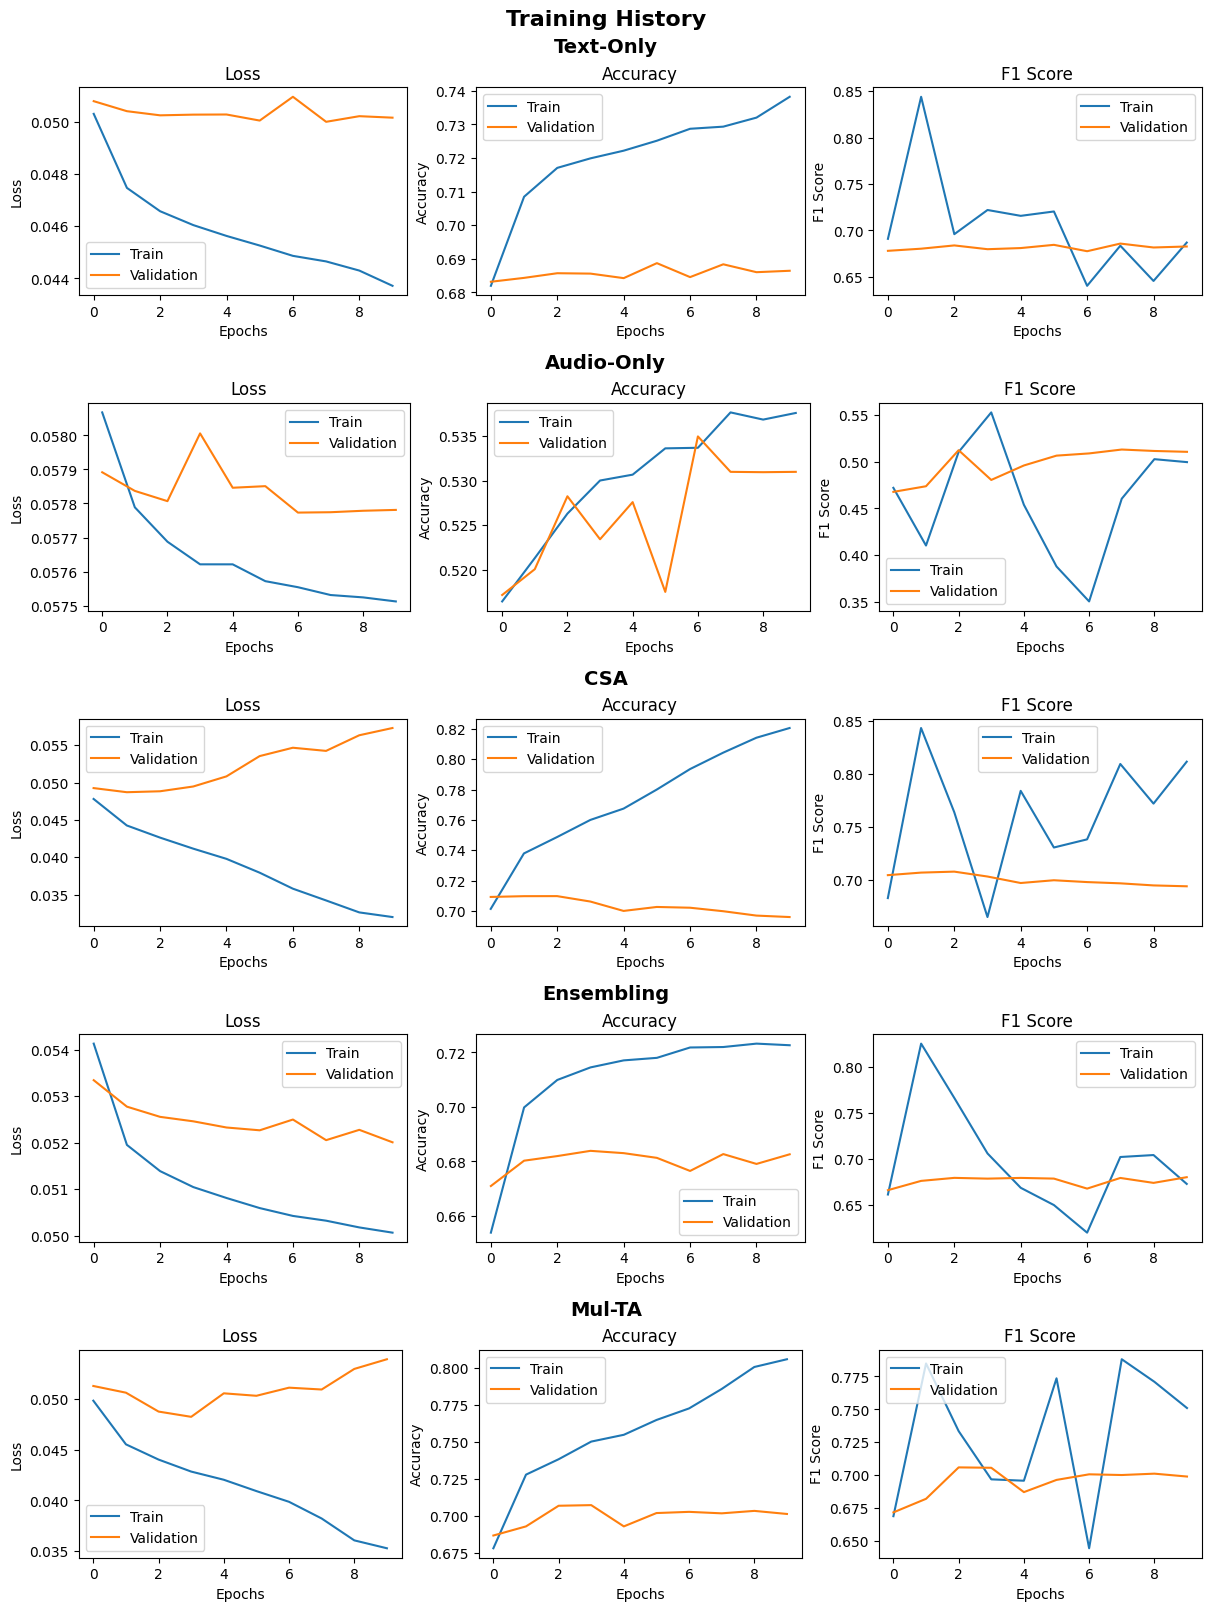

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(12, 16))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=5, ncols=1)
for (row, subfig), model_name in zip(enumerate(subfigs), history_train_losses.keys()):
    subfig.suptitle(f'{model_name}', fontsize=14, fontweight='bold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        if col == 0:
            ax.plot(np.mean(history_train_losses[model_name],axis=0), label='Train')
            ax.plot(np.mean(history_val_losses[model_name],axis=0), label='Validation')
            ax.set_title('Loss')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Loss')
            ax.legend()
        elif col == 1:
            ax.plot(np.mean(history_train_accuracy[model_name],axis=0), label='Train')
            ax.plot(np.mean(history_val_accuracy[model_name],axis=0), label='Validation')
            ax.set_title('Accuracy')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Accuracy')
            ax.legend()
        else:
            ax.plot(np.mean([[e.item() for e in ht_l] for ht_l in history_train_f1[model_name]], axis=0), label='Train')
            ax.plot(np.mean([[e.item() for e in ht_l] for ht_l in history_val_f1[model_name]], axis=0), label='Validation')
            ax.set_title('F1 Score')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('F1 Score')
            ax.legend()

Best results store for each model the results obtained in the seed which produced the highest F1 score

In [25]:
# taking the best results for each model based on the highest F1-score obtained in a seed
best_results = {
    model_name: max(test_results[model_name], key=lambda x: x['f1']) for model_name in test_results.keys()
}

## Mean and Standard Deviation for Accuracy, F1, AUC

In [26]:
# mean and standard deviation for the accuracy, F1 and AUC
aggregated_results = {}
for model_name, results in test_results.items():
    aggregated_results[model_name] = {
        'acc mean': torch.tensor([x['acc'] for x in results]).mean().item(),
        'acc std': torch.tensor([x['acc'] for x in results]).std().item(),
        'f1 mean': torch.tensor([x['f1'] for x in results]).mean().item(),
        'f1 std': torch.tensor([x['f1'] for x in results]).std().item(),
        'AUC mean': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).mean().item(),
        'AUC std': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).std().item(),
    }

# create multiindex dataframe with first level accuracy, f1 and second level mean and std
aggregated_results_df = pd.DataFrame(aggregated_results).T
aggregated_results_df.columns = pd.MultiIndex.from_product([['Accuracy', 'F1', 'AUC'], ['mean', 'std']])
aggregated_results_df.sort_values(by=('F1', 'mean'), ascending=False)

Accuracy          F1         AUC      
               mean   std  mean   std  mean   std
Mul-TA        0.701 0.004 0.700 0.004 0.701 0.003
CSA           0.699 0.005 0.698 0.006 0.698 0.005
Ensembling    0.683 0.003 0.681 0.003 0.682 0.003
Text-Only     0.681 0.002 0.679 0.002 0.680 0.002
Audio-Only    0.547 0.001 0.526 0.012 0.542 0.001

## ROC curves and AUC for the model in best_results

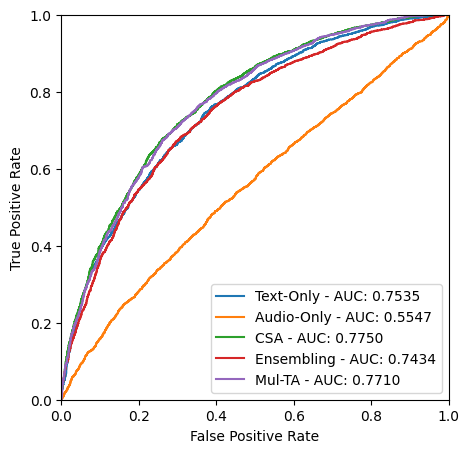

In [27]:
# plot ROC curves and compute AUC
plt.figure(figsize=(5, 5))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the ROC curve
    fpr, tpr, _ = roc_curve(best_result['targ'].cpu(), best_result['logits'].cpu())
    # compute the AUC
    auc = roc_auc_score(best_result['targ'].cpu(), best_result['logits'].cpu())
    # plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} - AUC: {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.xlim([0, 1])
plt.ylabel('True Positive Rate')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Precision-Recall curves for models in best_models

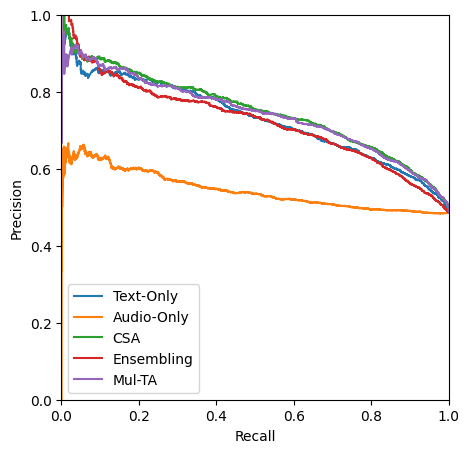

In [28]:
# plot precision-recall curves
plt.figure(figsize=(5, 5))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the precision-recall curve
    precision, recall, _ = precision_recall_curve(best_result['targ'].cpu(), best_result['logits'].cpu())
    # plot the precision-recall curve
    plt.plot(recall, precision, label=f'{model_name}')
plt.xlabel('Recall')
plt.xlim([0, 1])
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Confusion Matrix for models in best_models

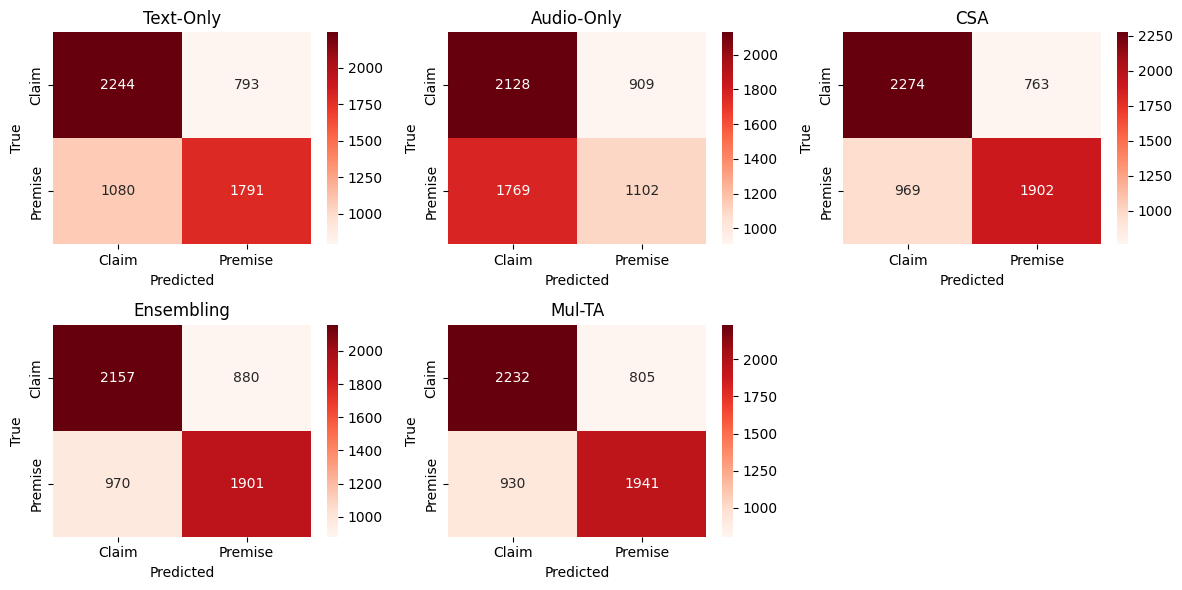

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, model_name in enumerate(test_results.keys()):
    best_result = best_results[model_name]
    
    cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_result['targ'].cpu()],
                      [ID_2_LABEL[label.item()] for label in best_result['pred'].cpu()])
                      
    sns.heatmap(cm, annot=True, ax=axes[i//3][i%3], fmt='d', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'], cmap='Reds')
    axes[i//3][i%3].set_title(model_name)
    axes[i//3][i%3].set_xlabel('Predicted')
    axes[i//3][i%3].set_ylabel('True')
axes[1][2].axis('off')
plt.tight_layout()
plt.show()

# Breakdown analysis on the Best performing model

Best performing model: Mul-TA
Accuracy: 0.7063
F1: 0.7056
AUC: 0.7055

              precision    recall  f1-score   support

       Claim       0.71      0.73      0.72      3037
     Premise       0.71      0.68      0.69      2871

    accuracy                           0.71      5908
   macro avg       0.71      0.71      0.71      5908
weighted avg       0.71      0.71      0.71      5908



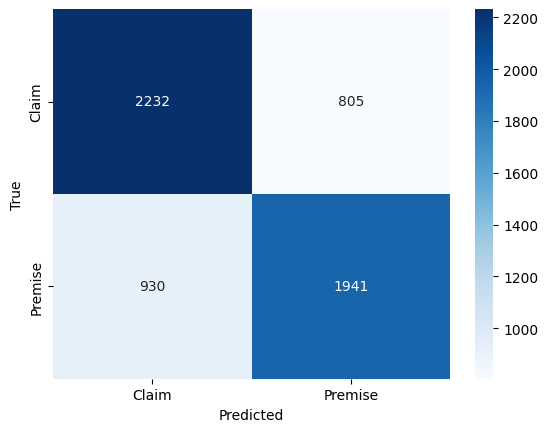

In [30]:
best_performing_model_name = max(aggregated_results_df['F1']['mean'].items(), key=lambda x: x[1])[0]

best_performing_model = max(test_results[best_performing_model_name], key=lambda x: x['f1'])

print(f'Best performing model: {best_performing_model_name}')
print(f'Accuracy: {best_performing_model["acc"]:.4f}')
print(f'F1: {best_performing_model["f1"]:.4f}')
print(f'AUC: {roc_auc_score(best_performing_model["targ"].cpu(), best_performing_model["pred"].cpu()):.4f}')
print()

print(classification_report([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                            [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])) 

cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                        [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])          

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()